# Food Recognition on Food 101 dataset

**Task:**<br>Food 101 is a labelled data set with 101 different food classes. Each food class contains 1000 images. Using the data provided,  a Machine Learning Model that can classify 15 classes in Food 101 dataset is created.

**The Setting:**
<br>**Classes: **("apple_pie", "club_sandwich", "cup_cakes", "donuts",
           "french_fries", "grilled_cheese_sandwich", "hamburger",
           "nachos", "pizza","ravioli", "samosa", "spring_rolls",
           "sushi", "tacos", "waffles")
<br>**Epoches: **100
<br>**Batch_size:** 64

In [1]:
import pandas as pd
import numpy as np
import keras
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, GlobalAveragePooling2D, Input, Activation
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping,CSVLogger
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from keras import backend as K

import os

Using TensorFlow backend.


# Data Augmentation

#### In order to avoid overfitting problem and to expand the dataset. Image data generator from Keras is used for image tranformation.

In [2]:
train_datagen = ImageDataGenerator(featurewise_center=False,
                 samplewise_center=False,
                 featurewise_std_normalization=False,
                 samplewise_std_normalization=False,
                 zca_whitening=False,
                 rotation_range=5,
                 width_shift_range=0.05,
                 height_shift_range=0.05,
                 shear_range=0.2,
                 zoom_range=0.2,
                 channel_shift_range=0.,
                 fill_mode='nearest',
                 cval=0.,
                 horizontal_flip=True,
                 vertical_flip=False,
                 rescale=1/255) #rescale to [0-1], add zoom range of 0.2x and horizontal flip
train_generator = train_datagen.flow_from_directory(
        "data/train",
        target_size=(224,224),
        batch_size=64)
test_datagen = ImageDataGenerator(rescale=1/255) # just rescale to [0-1] for testing set
test_generator = test_datagen.flow_from_directory(
        "data/test",
        target_size=(224,224),
        batch_size=64)

Found 11250 images belonging to 15 classes.
Found 3750 images belonging to 15 classes.


#### Just to make sure the image generator is working and the transformation is acceptable.

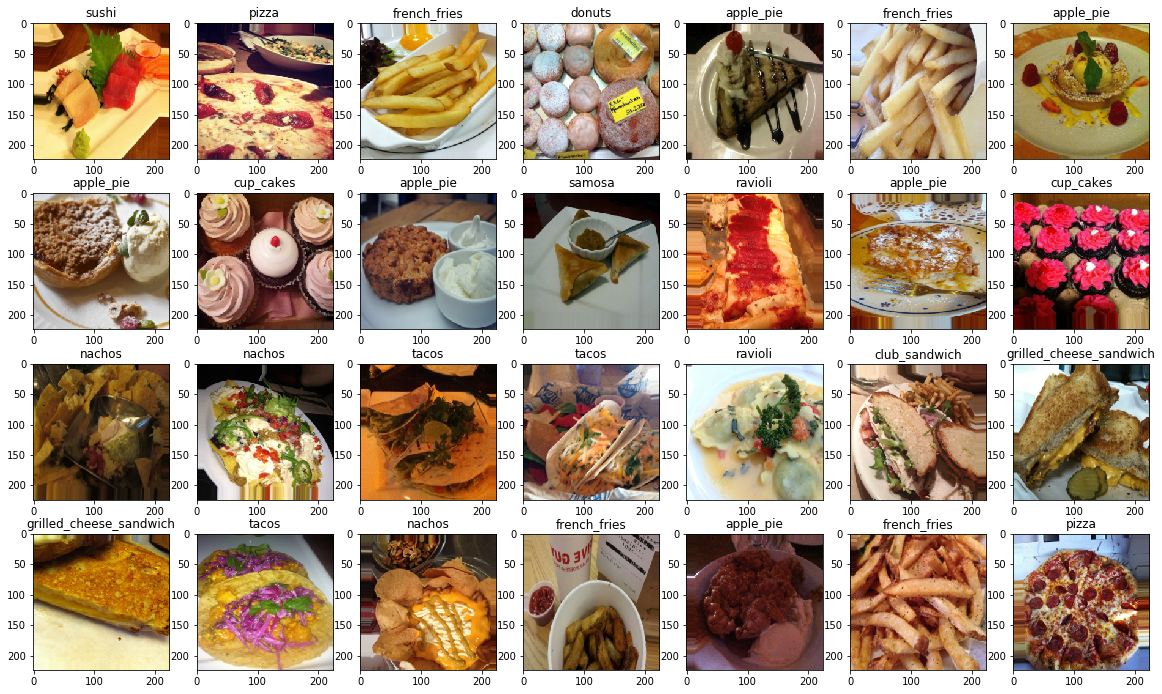

In [3]:
# preview images from train generator
r = 4; c = 7
n=0
classtolabel ={'0':"apple_pie",'1':"club_sandwich",'2':"cup_cakes",'3':"donuts",
           '4':"french_fries",'5':"grilled_cheese_sandwich",'6':"hamburger",
           '7':"nachos",'8':"pizza",'9':"ravioli",'10':"samosa",'11':"spring_rolls",
           '12':"sushi",'13':"tacos",'14':"waffles"}
for x in train_generator:
    fig, axes = plt.subplots(r,c,figsize=(20,12))
    for i in range(r):
        for j in range(c):
            axes[i,j].imshow(x[0][n])
            label = np.argmax(x[1],axis=1)[n].astype('str')
            axes[i,j].set_title(classtolabel[label])
            n+=1    
    break

# Modelling

In [4]:
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5), strides = 2, padding = 'Same', activation ='relu', input_shape = (224,224,3), kernel_initializer='he_normal'))
model.add(Conv2D(filters = 32, kernel_size = (5,5), strides = 2, padding = 'Same', activation ='relu',kernel_initializer='he_normal'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu',kernel_initializer='he_normal'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu',kernel_initializer='he_normal'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(filters = 128, kernel_size = (2,2),padding = 'Same', activation ='relu',kernel_initializer='he_normal'))
model.add(Conv2D(filters = 128, kernel_size = (2,2),padding = 'Same', activation ='relu',kernel_initializer='he_normal'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(filters = 256, kernel_size = (2,2),padding = 'Same', activation ='relu',kernel_initializer='he_normal'))
model.add(Conv2D(filters = 256, kernel_size = (2,2),padding = 'Same', activation ='relu',kernel_initializer='he_normal'))
model.add(GlobalAveragePooling2D())
model.add(Dense(512, activation = "relu",kernel_initializer='he_normal'))
model.add(Dropout(0.2))
model.add(Dense(15, activation = "softmax",kernel_initializer='he_normal',kernel_regularizer=l2()))

#callbacks
checkpointer = ModelCheckpoint(filepath='results/model.hdf5', verbose=1, save_best_only=True, save_weights_only=True)
earlystopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=20, mode='auto')
reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, mode='auto')

model.compile(optimizer = 'Adam' , loss = "categorical_crossentropy", metrics=["accuracy"])
csv_logger = CSVLogger('results/log')

Instructions for updating:
Colocations handled automatically by placer.


In [5]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 112, 112, 32)      2432      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 32)        25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 28, 28, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)       

In [6]:
history = model.fit_generator(train_generator,steps_per_epoch=11250/64,
                              validation_data=test_generator,validation_steps=3750/64, 
                              epochs=100, callbacks=[checkpointer, reduceLR, earlystopping,csv_logger])

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
176/175 [==============================] - 231s 1s/step - loss: 2.8341 - accuracy: 0.0769 - val_loss: 2.7247 - val_accuracy: 0.1040

Epoch 00001: val_loss improved from inf to 2.72469, saving model to method_2/model.hdf5
Epoch 2/100
176/175 [==============================] - 225s 1s/step - loss: 2.6770 - accuracy: 0.1012 - val_loss: 2.5767 - val_accuracy: 0.1029

Epoch 00002: val_loss improved from 2.72469 to 2.57672, saving model to method_2/model.hdf5
Epoch 3/100
176/175 [==============================] - 224s 1s/step - loss: 2.6464 - accuracy: 0.1064 - val_loss: 2.6087 - val_accuracy: 0.1035

Epoch 00003: val_loss did not improve from 2.57672
Epoch 4/100
176/175 [==============================] - 224s 1s/step - loss: 2.6328 - accuracy: 0.1053 - val_loss: 2.7380 - val_accuracy: 0.1125

Epoch 00004: val_loss did not improve from 2.57672
Epoch 5/100
176/175 [==============================] - 223s 1s/step - loss: 2.6166 - accur

In [23]:
# load weights from training with lowest val_loss
# model.load_weights('results/model.hdf5')

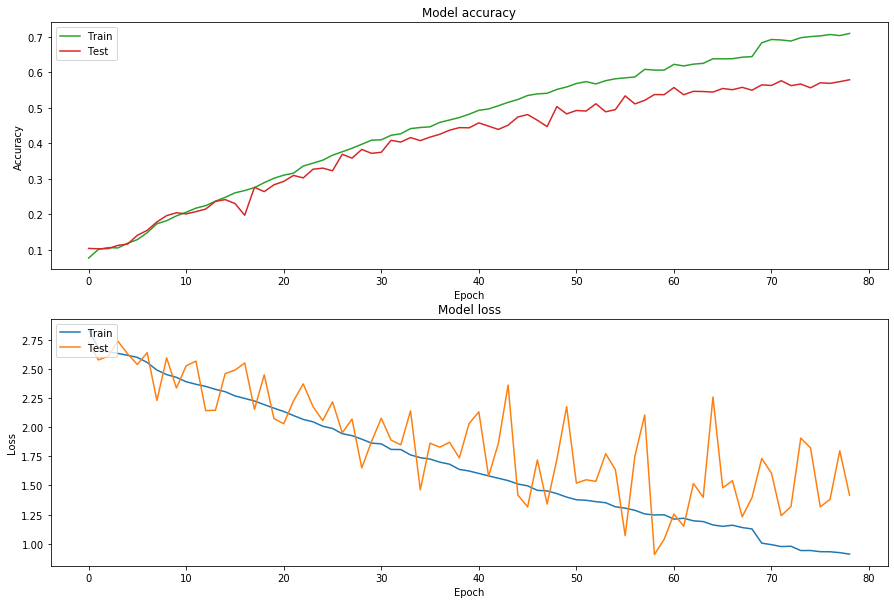

In [10]:
def plot_hist(history):
    f,ax = plt.subplots(2,1,figsize=(15,10))
    ax[0].plot(history.history['accuracy'],c='C2')
    ax[0].plot(history.history['val_accuracy'],c='C3')
    ax[0].set_title('Model accuracy')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['Train', 'Test'], loc='upper left')
    
    # summarize history for loss
    ax[1].plot(history.history['loss'],c='C0')
    ax[1].plot(history.history['val_loss'],c='C1')
    ax[1].set_title('Model loss')
    ax[1].set_ylabel('Loss')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Test'], loc='upper left')
    
plot_hist(history)

# Evaluate results

In [11]:
# create another generator for 750 test images in a single batch 
val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = test_datagen.flow_from_directory(
        "data/test",
        target_size=(224,224),
        batch_size=750)

Found 3750 images belonging to 15 classes.


In [12]:
x_test, y_test = val_generator.next()
y_pred_conf = model.predict(x_test) #return probabilities of each class
y_pred = np.argmax(y_pred_conf,axis=1)
y_label = np.argmax(y_test,axis=1)

print('Accuracy score: {:.1f}%'.format(accuracy_score(y_pred,y_label)*100))

Accuracy score: 55.7%


### Randomly check 5 predictions

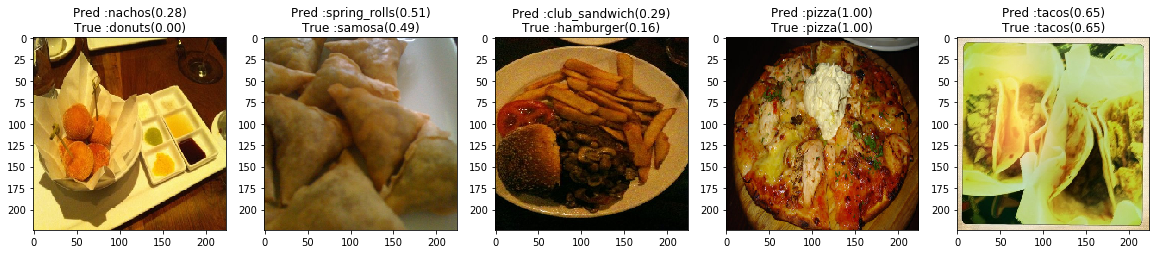

In [13]:
ind = np.random.randint(1,len(x_test),5)
f, ax=plt.subplots(1,5,figsize=(20,10))
for i,j in enumerate(ind):
    ax[i].imshow(x_test[j])
    ax[i].set_title("Pred :{}({:.2f})\nTrue :{}({:.2f})".format
                          (classtolabel[str(y_pred[j])],np.max(y_pred_conf[j]),
                           classtolabel[str(y_label[j])],y_pred_conf[j][(y_label[j])],fontweight="bold", size=20))


### Confusion Matrix

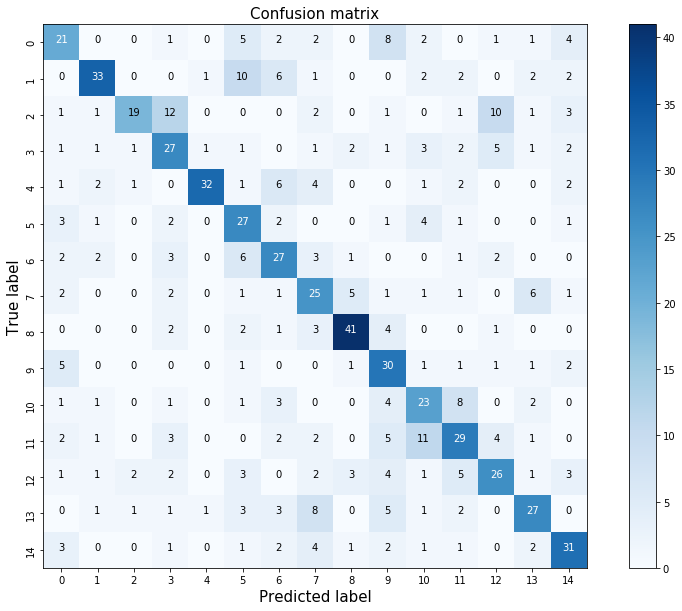

In [25]:
def plot_confusion_matrix(cm):
    plt.rcParams["figure.figsize"] = (15,10)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix',fontsize=15)
    plt.colorbar()
    plt.xticks(np.arange(15), fontsize=10)
    plt.yticks(np.arange(15), fontsize=10,rotation=90,verticalalignment="center")
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center", color="white" if cm[i, j] > np.max(cm)/2. else "black")
    plt.xlabel('Predicted label',fontsize=15)
    plt.ylabel('True label',fontsize=15)
    
plot_confusion_matrix(confusion_matrix(y_label,y_pred))

### ROC Curve

In [37]:
fpr = dict() # false positive rate
tpr = dict() # true positive rate
roc_auc = dict() # area under roc curve
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_conf[:, i]) # roc_curve function apply to binary class only
    roc_auc[i] = auc(fpr[i], tpr[i])  # using the trapezoidal rule to get area under curve

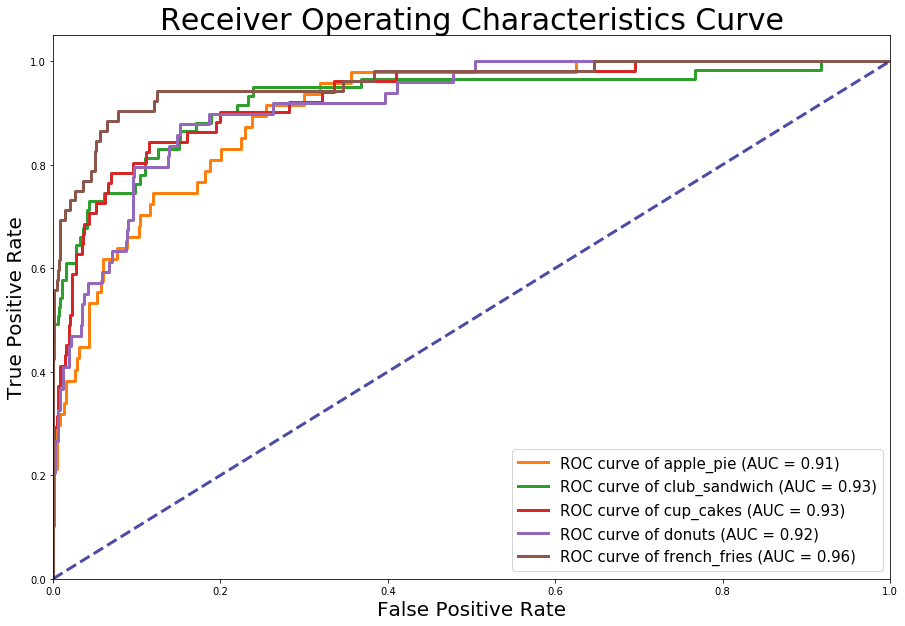

In [38]:
def plot_roc(fpr,tpr,roc_auc):
    plt.figure(figsize=(15,10))
    plt.plot(fpr[0], tpr[0], color='C1', lw=3, label='ROC curve of apple_pie (AUC = %0.2f)' % roc_auc[0])
    plt.plot(fpr[1], tpr[1], color='C2', lw=3, label='ROC curve of club_sandwich (AUC = %0.2f)' % roc_auc[1])
    plt.plot(fpr[2], tpr[2], color='C3', lw=3, label='ROC curve of cup_cakes (AUC = %0.2f)' % roc_auc[2])
    plt.plot(fpr[3], tpr[3], color='C4', lw=3, label='ROC curve of donuts (AUC = %0.2f)' % roc_auc[3])
    plt.plot(fpr[4], tpr[4], color='C5', lw=3, label='ROC curve of french_fries (AUC = %0.2f)' % roc_auc[4])
    plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--',alpha=0.7)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate',fontsize=20)
    plt.ylabel('True Positive Rate',fontsize=20)
    plt.title('Receiver Operating Characteristics Curve',fontsize=30)
    plt.legend(loc="lower right",fontsize=15)
    plt.show()

plot_roc(fpr,tpr,roc_auc)